<a href="https://colab.research.google.com/github/yovelop/NN/blob/master/NN_Energy_Predictor_0.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
DIR = '/content/drive/My Drive/Colab Notebooks/ENSaver/'
#drive.flush_and_unmount()

Mounted at /content/drive


In [0]:
#Импорты
  import numpy as np # linear algebra
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
  import gc

  import matplotlib.pyplot as plt
  import matplotlib.style
  matplotlib.style.use('ggplot')

  from sys import getsizeof

  import os
  for dirname, _, filenames in os.walk(DIR):
      for filename in filenames:
          print(os.path.join(dirname, filename))

  pd.options.mode.chained_assignment = None  # default='warn'
  import warnings
  pd.set_option('display.max_rows', 500)
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.width', 100)
  warnings.filterwarnings('ignore')
  np.set_printoptions (precision = 4, suppress  = True)

  def reduce_mem_usage(df):
      start_mem_usg = df.memory_usage().sum() / 1024**2 
      print("Memory usage of properties dataframe is :",start_mem_usg," MB")
      NAlist = [] # Keeps track of columns that have missing values filled in. 
      for col in df.columns:
          if (df[col].dtype != object) &  (df[col].dtype != 'datetime64[ns]'):  # Exclude strings            
              # Print current column type
              print("******************************")
              print("Column: ",col)
              print("dtype before: ",df[col].dtype)            
              # make variables for Int, max and min
              IsInt = False
              mx = df[col].max()
              mn = df[col].min()
              print("min for this col: ",mn)
              print("max for this col: ",mx)
              # Integer does not support NA, therefore, NA needs to be filled
              if not np.isfinite(df[col]).all(): 
                  NAlist.append(col)
                  df[col].fillna(mn-1,inplace=True)  
                    
              # test if column can be converted to an integer
              asint = df[col].fillna(0).astype(np.int64)
              result = (df[col] - asint)
              result = result.sum()
              if result > -0.01 and result < 0.01:
                  IsInt = True            
              # Make Integer/unsigned Integer datatypes
              if IsInt:
                  if mn >= 0:
                      if mx < 255:
                          df[col] = df[col].astype(np.uint8)
                      elif mx < 65535:
                          df[col] = df[col].astype(np.uint16)
                      elif mx < 4294967295:
                          df[col] = df[col].astype(np.uint32)
                      else:
                          df[col] = df[col].astype(np.uint64)
                  else:
                      if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                          df[col] = df[col].astype(np.int8)
                      elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                          df[col] = df[col].astype(np.int16)
                      elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                          df[col] = df[col].astype(np.int32)
                      elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                          df[col] = df[col].astype(np.int64)    
              # Make float datatypes 32 bit
              else:
                  df[col] = df[col].astype(np.float32)
              
              # Print new column type
              print("dtype after: ",df[col].dtype)
              print("******************************")
      # Print final result
      print("___MEMORY USAGE AFTER COMPLETION:___")
      mem_usg = df.memory_usage().sum() / 1024**2 
      print("Memory usage is: ",mem_usg," MB")
      print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
      return df, NAlist

  def show_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.show()
    
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1,2])
    plt.legend(['Train','Val'])
    plt.show()

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0,1])
    plt.legend(['Train','Val'])
    plt.show()

In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater
#  Подготовка данных
  df = pd.read_csv(DIR + "train.csv", engine = 'python')
  #df_test = pd.read_csv(DIR + "test.csv", engine = 'python')

  df['timestamp'] = pd.to_datetime(df['timestamp'])
  #df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

  #Очистка от корявых данных
  #df = df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

  #df['meter_reading'] = np.log1p(df['meter_reading'])

  #df = pd.concat([df_train, df_test], sort=False)

  df['hour_cos'] = np.cos(df['timestamp'].dt.hour * 2 * np.pi / 24)
  df['hour_sin'] = np.sin(df['timestamp'].dt.hour * 2 * np.pi / 24)

  df['weekday_cos'] = np.cos(df['timestamp'].dt.weekday * 2 * np.pi / 7)
  df['weekday_sin'] = np.sin(df['timestamp'].dt.weekday * 2 * np.pi / 7)

  df['week_cos'] = np.cos(df['timestamp'].dt.week * 2 * np.pi / 53)
  df['week_sin'] = np.sin(df['timestamp'].dt.week * 2 * np.pi / 53)

  #df_train['weekends'] = (df_train['weekday'] >= 6) * 1

In [0]:
#Очистка от подозрительных нулей
  #print(df[df['building_id']==2][['timestamp','meter_reading','meter','ds_zero','de_zero','is_bad_zero']].head(20))
  df = df.sort_values(by = ['meter','building_id','timestamp'])
  df['meter_reading_prev'] = 0

  #for bid in df['building_id'].unique():
  #  for met in df['meter'].unique():
  df['meter_reading_prev'] = df['meter_reading'].shift()
  df['is_equal_prev']= (df['meter_reading_prev'] == df['meter_reading'] )*1

  df['day'] = df['timestamp'].dt.dayofyear
  df_bad_rows = df.groupby(by=['building_id','day','meter'], as_index = False)['is_equal_prev'].mean()
  df_bad_rows.rename({"is_equal_prev": "IS_BAD_PRCNT"}, axis='columns', inplace=True)

  df = pd.merge(df, df_bad_rows, how = 'inner', on = ['building_id','day','meter'])
  #print(df_bad_rows[df_bad_rows['building_id']==109].head(365))
  del df_bad_rows 

  #print(df[df['building_id']==2][['timestamp','meter_reading','is_equal_prev','IS_BAD_PRCNT','day']].head(30))

In [0]:
# Добавление медианы по метрике постройки
  df_median = df.groupby(by=['building_id','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_median'
  df = pd.merge(df, df_median, how = 'inner', on = ['building_id','meter'])
  del df_median 
# Добавление медианы по часу, по неделе, метрике постройки
  df['hour'] = df['timestamp'].dt.hour
  df_median = df.groupby(by=['building_id','hour','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_hour_median'
  df = pd.merge(df, df_median, how = 'inner', on = ['building_id','hour','meter'])
  del df_median 

  df['weekday'] = df['timestamp'].dt.weekday
  df_median = df.groupby(by=['building_id','weekday','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_weekday_median'
  df = pd.merge(df, df_median, how = 'inner', on = ['building_id','weekday','meter'])
  del df_median 
#Подстановка параметров сооружения
  building_df = pd.read_csv(DIR + "building_metadata.csv", engine = 'python')
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  building_df["primary_use_ID"] = le.fit_transform(building_df["primary_use"])

  building_df['primary_use'] = building_df['primary_use'].astype('category')
  building_df = pd.get_dummies(building_df)

  df = df.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
  df.head(5)
  del building_df

In [0]:
#Вставка данных погоды
#Восстановление пустых данных погоды через соседей по линейной инетрполяции
  df_weather = pd.read_csv(DIR + "weather_train.csv", engine = 'python')
  df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

  #weather_train.groupby('site_id').apply(lambda group: group.isna().sum())
  df_times = df.drop_duplicates(['site_id','timestamp'])[['site_id','timestamp']]
  df_times = pd.merge(df_times, df_weather, how = 'left', on = ['site_id','timestamp'])
  df_times = df_times.sort_values(by = ['site_id','timestamp'])
  
  df_times = df_times.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
  df = pd.merge(df, df_times, how = 'left', on = ['site_id','timestamp'])
  #del df_weather

In [0]:
#Инфо о корявости данных:
  print('0 Всего:',df[df['meter']==0].shape, 'Откинуть:', df[(df['meter']==0) & (df['IS_BAD_PRCNT']>0.45)].shape)
  print('1 Всего:',df[df['meter']==1].shape, 'Откинуть:', df[(df['meter']==1) & (df['IS_BAD_PRCNT']>0.75)].shape)
  print('2 Всего:',df[df['meter']==2].shape, 'Откинуть:', df[(df['meter']==2) & (df['IS_BAD_PRCNT']>0.75)].shape)
  print('3 Всего:',df[df['meter']==3].shape, 'Откинуть:', df[(df['meter']==3) & (df['IS_BAD_PRCNT']>0.75)].shape)

0 Всего: (12060910, 47) Откинуть: (1401057, 47)
1 Всего: (4182440, 47) Откинуть: (537615, 47)
2 Всего: (2708713, 47) Откинуть: (223436, 47)
3 Всего: (1264037, 47) Откинуть: (311410, 47)


In [0]:
# df_times = df.drop_duplicates(['site_id','hour','dayofyear'])[['site_id','hour','dayofyear']]
# df_times = pd.merge(df_times, df_weather, how = 'left', on = ['site_id','timestamp'])
# df_times = df_times.sort_values(by = ['site_id','timestamp'])
# df_times = df_times.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
# df_times.to_feather(DIR + 'DF_WEATHER_BY_DAY_and_HOUR.FTHR')
# del df_times

In [0]:
#Вывести кол-во пустот по полям. Затем заполнить из средним значением по полю
  for col in df.columns:
    print(col)
    for met in df['meter'].unique():
      if np.sum(df[col].isnull()) > 0:
        print(met)
        print(np.sum(df[col].isnull()))

        df_col = df.groupby(by=['building_id','meter'], as_index = False)[col].mean()
        df_col.rename({col: "tmp"}, axis='columns', inplace=True)
        df = df.merge(df_col, left_on = ['building_id','meter'], right_on = ['building_id','meter'], how = "left")
        df[col].fillna( df_col['tmp'], inplace = True)
        df.drop(columns = ['tmp'],inplace = True)
        del df_col

        df_col = df.groupby(by=['meter'], as_index = False)[col].mean()
        df_col.rename({col: "tmp"}, axis='columns', inplace=True)
        df = df.merge(df_col, left_on = ['meter'], right_on = ['meter'], how = "left")
        df[col].fillna( df_col['tmp'], inplace = True)
        df.drop(columns = ['tmp'],inplace = True)
        del df_col

        df[col].fillna( df[col].mean(), inplace = True)

In [0]:
#df.to_feather(DIR + 'DF_TRAIN_EXTENDED2.FTHR')
#df = pd.read_feather(DIR + 'DF_TRAIN_EXTENDED2.FTHR')
reduce_mem_usage(df)
df.to_feather(DIR + 'DF_TRAIN_REDUCED2.FTHR')
gc.collect()

  Скорость

In [5]:

df = pd.read_feather(DIR + 'DF_TRAIN_REDUCED2.FTHR')
gc.collect()

0

In [0]:
df.describe()

In [6]:
#Импорты Керас:
  from keras.models import Sequential, load_model

  from keras.layers import Dense
  from keras.initializers import TruncatedNormal, Constant
  from keras.regularizers import l1,l2,l1_l2
  from keras.optimizers import Adam
  import keras.backend as K

  from keras. callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
  #from keras.utils import plot_model
  from keras.losses import mean_squared_error as mse #, mean_absolute_percentage_error as mape

  def RMSLE(y_true, y_pred):
    return K.pow( K.mean( K.pow(K.log(y_true+1) - K.log(y_pred+1),2.00000)),0.5000)

  def tweedieloss(y_true, y_pred):
      return K.mean(  K.pow(    K.pow(backend.maximum(0.000,K.maximum(0.013000,y_true)),0.5)  -   K.pow(K.maximum(0.013000,y_pred),0.5)   , 2 ) / K.pow(K.maximum(0.013000,y_pred),0.5)
                  )

  def tweedieloss_bkp(y_true, y_pred):
      p=1.5
      dev = 2 * (K.pow(K.maximum(0.000,y_true), 2-p)/((1-p) * (2-p)) -
                    y_true * K.pow(y_pred, 1-p)/(1-p) +
                    K.pow(y_pred, 2-p)/(2-p))
      return K.mean(dev)

  def VAL_ (y_true, y_pred):
      return  K.maximum(0.0330000, K.sum(y_pred))/ K.maximum(0.033000, K.sum(y_true)) 
      
  def VAL_2 (y_true, y_pred):
      return  K.minimum( 5.000000, K.exp ( K.abs( K.log( VAL_ (y_true, y_pred))))-1)
  
  def VAL_3 (y_true, y_pred):
      return  K.exp ( K.abs( K.log( VAL_ (y_true, y_pred))))-1

  def MAPE_ (y_true, y_pred):
      return K.mean( K.minimum( 5.000000,  K.abs(y_true - y_pred)/ K.maximum(0.033000, y_true)) )
      
  def MAE_(y_true, y_pred):
      return K.sum( K.abs(y_true - y_pred))/ K.maximum(0.033000, K.sum(y_true))

  def MSE_(y_true, y_pred):
      return K.sum( K.pow(y_true - y_pred,2.00000))/ K.maximum(0.033000,  K.sum(K.pow(y_true,2.00000)))

  def MAE_MAPE(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          +  0.250000 * MAPE_ (y_true, y_pred)
      )
              
  def MAE_VAL_MAPE(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          + 1.800000 *   VAL_2 (y_true, y_pred)          
          + 0.950000 *   MAPE_ (y_true, y_pred)
          )

  def MAE_VAL(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          + 0.800000 *   VAL_2 (y_true, y_pred)                     
              )

  def MAPE_VAL(y_true, y_pred):
      return (
                      MAPE_ (y_true, y_pred)
          + 0.4000 *  VAL_2 (y_true, y_pred)             
              )

  def MSE_VAL_MAPE(y_true, y_pred):
      return (
            5.000000 *   MSE_(y_true, y_pred)
          + 2.200000 *   VAL_2 (y_true, y_pred)          
          + 0.750000 *   MAPE_ (y_true, y_pred)
          )

  def MASPE_VAL(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)               
          + 0.500000 *   MSE_(y_true, y_pred)
          + 1.200000 *   VAL_2 (y_true, y_pred)          
          + 0.250000 *   MAPE_ (y_true, y_pred)
          )
  
  def MAE_RMSLE(y_true, y_pred):
      return (
            1.000000 *   MAE_   (y_true, y_pred)
          + 2.000000 *   RMSLE  (y_true, y_pred)          
          )  

  def MAPE_RMSLE(y_true, y_pred):
      return (
            1.000000 *   MAPE_   (y_true, y_pred)
          + 0.100000 *   RMSLE  (y_true, y_pred)          
          )  
  
  def MAPE_VAL_RMSLE(y_true, y_pred):
      return (
            1.000000 *   MAPE_   (y_true, y_pred)
          + 1.000000 *   RMSLE   (y_true, y_pred)    
          + 1.000000 *   VAL_2   (y_true, y_pred)      
          )  
 
  import keras.metrics
  keras.metrics.MAE_ = MAE_
  keras.metrics.VAL_ = VAL_
  keras.metrics.VAL_2 = VAL_2
  keras.metrics.MAPE_ = MAPE_
  keras.metrics.MSE_ = MSE_
  keras.metrics.tweedieloss = tweedieloss
  keras.metrics.MAE_RMSLE = MAE_RMSLE
  keras.metrics.MAPE_RMSLE = MAPE_RMSLE
  keras.metrics.MAPE_VAL_RMSLE = MAPE_VAL_RMSLE
  keras.metrics.RMSLE = RMSLE

  import keras.losses
  keras.losses.MAE_VAL_MAPE = MAE_VAL_MAPE
  keras.losses.MSE_VAL_MAPE = MSE_VAL_MAPE
  keras.losses.MAE_ = MAE_
  keras.losses.MASPE_VAL = MASPE_VAL
  keras.losses.tweedieloss = tweedieloss
  keras.losses.MAE_RMSLE = MAE_RMSLE
  keras.losses.MAPE_RMSLE = MAPE_RMSLE
  keras.losses.MAPE_VAL_RMSLE = MAPE_VAL_RMSLE
  keras.losses.RMSLE = RMSLE

  class MyCustomCallback(keras.callbacks.Callback):
    
    def __init__(self, epochs, stats_print_step): 
        
        self.__epochs = epochs
        self.__stats_print_step = stats_print_step
    
    def on_train_begin(self, logs={}):
        pass
        #print('on_train_begin', logs)
 
    def on_train_end(self, logs={}):
        pass
        #print('on_train_end', logs)
 
    def on_epoch_begin(self, epoch, logs={}):
        pass
 
    def on_epoch_end(self, epoch, logs={}):
        if ((epoch < 5) or (epoch % self.__stats_print_step == 0)) :
            print('# ' + str('{:04d}'.format(epoch + 1)) + ' | ' + self.get_stats_by_epoch(logs))
        if epoch == 2:
            print('.......')
        if epoch == self.__epochs - 1:
            print('# ' + str('{:04d}'.format(epoch + 1)) + ' | ' + self.get_stats_by_epoch(logs))
        else:
            print('# ' + str('{:04d}'.format(epoch + 1)) + ' | ' + self.get_stats_by_epoch(logs), end="\r")
 
    def on_batch_begin(self, batch, logs={}):
        pass
        #print('on_batch_begin', batch, logs)
 
    def on_batch_end(self, batch, logs={}):
        pass
        #print('on_batch_end', batch, logs)

    def get_stats_by_epoch(self, logs):
        
        is_test = True
        s = ''
        
        for key, value in logs.items(): 
            if is_test:
                if 'val_' not in str(key):
                    s += ' /// '
                    is_test = False
            if is_test:
                s += ' ' + str(key).replace('val_', 'TST_') + ': ' + "{0:.4f}".format(value)
            else:
                s += ' ' + 'TRN_' + str(key) + ': ' + "{0:.4f}".format(value)

        return s #'val_loss: ' + "{0:.4f}".format(logs['val_loss']) + ' | loss: ' + "{0:.4f}".format(logs['loss'])

Using TensorFlow backend.


In [0]:
df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'hour_cos', 'hour_sin', 'weekday_cos',
       'weekday_sin', 'week_cos', 'week_sin', 'meter_reading_prev', 'is_equal_prev', 'day',
       'IS_BAD_PRCNT', 'building_meter_median', 'hour', 'building_meter_hour_median', 'weekday',
       'building_meter_weekday_median', 'site_id', 'square_feet', 'year_built', 'floor_count',
       'primary_use_ID', 'primary_use_Education', 'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential', 'primary_use_Manufacturing/industrial',
       'primary_use_Office', 'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship', 'primary_use_Retail',
       'primary_use_Services', 'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_dep

In [7]:
Out_Columns = 'meter_reading'
In_Columns = [ 'hour_cos','hour_sin', 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin',
       'site_id', 'square_feet', 'year_built', 'floor_count', #'primary_use_ID',
       'primary_use_Education', 'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'
       , 'building_meter_median','building_meter_hour_median','building_meter_weekday_median']
# Нормализация
 if 1==1:
  from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
  scaler =  MinMaxScaler (copy=True, feature_range=(0, 1))                                  #quantile_range  = (15.0,85.0)) #Normalizer #(copy=True, feature_range=(-1, 1)) # MinMaxScaler(copy=True, feature_range=(-1, 1)) #StandardScaler() #MinMaxScaler(copy=True, feature_range=(-1, 1)) # RobustScaler()
  scaler.fit( df[In_Columns] )
  df[In_Columns]     = pd.DataFrame(data = scaler.transform( df[In_Columns])    , columns = df[In_Columns].columns   , index=df.index) 

  df.fillna(0.33)
  gc.collect()

IndentationError: ignored

In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater
# РАСЧЁТ НЕЙРОНОК:
  reg = 0.00001
  batch_size = 2048
  epochs = 50
  meter = 0

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  init = TruncatedNormal(mean=0.0, stddev=0.05, seed=159)
  bias = Constant(value = 1e-3)
  
  if 0==0:
    meter = 0
    opt = Adam(lr = 0.009)

    nn_0 = Sequential()
    nn_0.add(Dense(60, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l1(reg), kernel_initializer = 'normal'))
    nn_0.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal'))
    nn_0.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

    nn_0.compile(optimizer = opt, loss = MAE_RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
    
    val = df[(df['meter']==meter) & (df['day']%6==0)]
    hist = nn_0.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][Out_Columns], batch_size = batch_size, verbose = 1
                    , epochs = epochs, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss,model_checkpoint]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                    ) 
    nn_0.save(DIR + str(meter) + 'HANDLY_SAVED2.MODEL')
    gc.collect()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 10659833 samples, validate on 2010873 samples
Epoch 1/50





10659833/10659833 [==============================] - 47s 4us/step - loss: 2.2828 - MAE_: 0.5814 - RMSLE: 0.8457 - VAL_: 0.5186 - mean_squared_error: 96750.6682 - val_loss: 1.9125 - val_MAE_: 0.3594 - val_RMSLE: 0.7690 - val_VAL_: 0.9697 - val_mean_squared_error: 109953.7138
Epoch 2/50
10659833/10659833 [==============================] - 37s 3us/step - loss: 1.3292 - MAE_: 0.3683 - RMSLE: 0.4719 - VAL_: 0.7129 - mean_squared_error: 69628.5752 - val_loss: 1.7638 - val_MAE_: 0.3043 - val_RMSLE: 0.7206 - val_VAL_: 0.9422 - val_mean_squared_error: 98766.7754
Epoch 3/50
10659833/10659833 [==============================] - 37s 4us/step - loss: 1.2114 - MAE_: 0.3237 - RMSLE: 0.4342 - VAL_: 0.7621 - mean_squared_error: 61632.4418 - val_loss: 1.8411 - val_MAE_: 0.3152 - val_RMSLE: 0.7530 - val_VAL_: 0.8593 - val_mean_squared_

In [0]:
# hist = nn_0.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][Out_Columns], batch_size = batch_size, verbose = 1
#               , epochs = epochs, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss,model_checkpoint]
#               , validation_data=(val[In_Columns], val[Out_Columns])
#               ) 

In [0]:
 #Продолжение расчёта
 if 9==9:
    # nn_0.optimizer.lr = 0.007
    # nn_0.compile(optimizer = opt, loss = MAE_RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse' ])
    # batch_size = 2048
    # epochs = 10
    
    # earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min',restore_best_weights = True)
    # reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, verbose=1, min_delta=1e-3, mode='min')

    # val = df[(df['meter']==meter) & (df['day']%6==0)]
    # hist = nn_0.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][Out_Columns], batch_size = batch_size, verbose = 1
    #                 , epochs = epochs, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss,model_checkpoint]
    #                 , validation_data=(val[In_Columns], val[Out_Columns])
    #                 ) 

In [0]:
if 1==1:
  reg = 0.00001
  meter = 1
  epochs = 100
  batch_size = 512
  opt = Adam(lr = 0.007)

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_1 = Sequential()
  nn_1.add(Dense(90, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l1(reg), kernel_initializer = 'normal'))
  nn_1.add(Dense(90, activation = 'tanh',  kernel_initializer = 'normal'))
  nn_1.add(Dense(90, activation = 'relu',  kernel_initializer = 'normal'))
  nn_1.add(Dense(90, activation = 'relu',  kernel_initializer = 'normal'))
  nn_1.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

  nn_1.compile(optimizer = opt, loss = MAE_RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[(df['meter']==meter) & (df['day']%6==0)]
  hist = nn_1.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][Out_Columns], batch_size = batch_size, verbose = 1
                  , epochs = epochs, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_1.save(DIR + str(meter) + 'HANDLY_SAVED2.MODEL')
  gc.collect()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3480650 samples, validate on 697348 samples
Epoch 1/100





3480650/3480650 [==============================] - 39s 11us/step - loss: 2.6861 - MAE_: 0.4389 - RMSLE: 1.1175 - VAL_: 0.7426 - mean_squared_error: 74046388.2225 - MAPE_: 0.8844 - val_loss: 2509.1781 - val_MAE_: 2506.5146 - val_RMSLE: 1.3233 - val_VAL_: 2506.9814 - val_mean_squared_error: 62661875.2025 - val_MAPE_: 1.3179
Epoch 2/100
3480650/3480650 [==============================] - 33s 9us/step - loss: 2.1056 - MAE_: 0.3263 - RMSLE: 0.8802 - VAL_: 0.8469 - mean_squared_error: 72271500.8472 - MAPE_: 0.6802 - val_loss: 2461.9575 - val_MAE_: 2459.2906 - val_RMSLE: 1.3231 - val_VAL_: 2459.9241 - val_mean_squared_error: 61179016.9324 - val_MAPE_: 1.3326
Epoch 3/100
3480650/3480650 [==============================] - 33s 10us/step - loss: 2.0247 - MAE_: 0.3121 - RMSLE: 0.8452 - VAL_: 0.8562 - mean_squared_error: 67148874.8206 

In [0]:
if 2==2:
  reg = 0.000001
  meter = 2
  epochs = 30
  batch_size = 200
  opt = Adam(lr = 0.002)

  earlyStopping = EarlyStopping(monitor='loss', patience=30, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=55, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_2 = Sequential()
  nn_2.add(Dense(90, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l1(reg), kernel_initializer = keras.initializers.RandomUniform(minval=-0.25, maxval=0.25, seed=None), bias_initializer=keras.initializers.Constant(0.1)))
  nn_2.add(Dense(90, activation = 'tanh',  kernel_initializer = keras.initializers.RandomUniform(minval=-0.25, maxval=0.25, seed=None), bias_initializer=keras.initializers.Constant(0.1)))
  nn_2.add(Dense( 1, activation = 'relu', kernel_initializer = 'normal'))

  nn_2.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[(df['meter']==meter) & (df['day']%6==0)]
  hist = nn_2.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.75)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.75)][Out_Columns], batch_size = batch_size, verbose = 1
                  , epochs = epochs, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_2.save(DIR + str(meter) + 'HANDLY_SAVED2.MODEL')
  gc.collect()

Train on 2472929 samples, validate on 452118 samples
Epoch 1/30
2472929/2472929 [==============================] - 49s 20us/step - loss: 2.0180 - MAE_: 0.9270 - RMSLE: 2.0170 - VAL_: 0.0941 - mean_squared_error: 191872564395.5270 - MAPE_: 1.1104 - val_loss: 1.6678 - val_MAE_: 541.4093 - val_RMSLE: 1.6659 - val_VAL_: 541.2938 - val_mean_squared_error: 169433291613.2108 - val_MAPE_: 1.2422
Epoch 2/30
2472929/2472929 [==============================] - 48s 19us/step - loss: 1.5503 - MAE_: 0.8697 - RMSLE: 1.5481 - VAL_: 0.1540 - mean_squared_error: 191862971330.2757 - MAPE_: 0.9241 - val_loss: 1.5453 - val_MAE_: 464.9667 - val_RMSLE: 1.5428 - val_VAL_: 464.9392 - val_mean_squared_error: 169428064791.7653 - val_MAPE_: 1.1740
Epoch 3/30
2472929/2472929 [==============================] - 47s 19us/step - loss: 1.4483 - MAE_: 0.8475 - RMSLE: 1.4455 - VAL_: 0.1779 - mean_squared_error: 191858303957.0333 - MAPE_: 0.8800 - val_loss: 1.4738 - val_MAE_: 615.4066 - val_RMSLE: 1.4708 - val_VAL_: 615.41

In [0]:
# lr = 0.002 , 0.003, 
#nn_2 = keras.models.load_model (DIR + '2HANDLY_SAVED2.MODEL')
opt = Adam(lr = 0.003)
batch_size = 100
epochs = 7
nn_2.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
hist = nn_2.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.75)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.75)][Out_Columns], batch_size = batch_size, verbose = 1
                , epochs = epochs, shuffle = True, callbacks=[ earlyStopping, reduce_lr_loss,model_checkpoint] #MyCustomCallback(epochs, 1),
                , validation_data=(val[In_Columns], val[Out_Columns])
                ) 
#nn_2.save(DIR + str(meter) + 'HANDLY_SAVED2.MODEL')
gc.collect()

Train on 2472929 samples, validate on 452118 samples
Epoch 1/7
2472929/2472929 [==============================] - 95s 38us/step - loss: 1.1182 - MAE_: 0.6283 - RMSLE: 1.1081 - VAL_: 0.4489 - mean_squared_error: 191791595936.2869 - MAPE_: 0.7218 - val_loss: 1.2308 - val_MAE_: 1932.1225 - val_RMSLE: 1.2206 - val_VAL_: 1932.5107 - val_mean_squared_error: 169366125348.6926 - val_MAPE_: 0.9620
Epoch 2/7
2472929/2472929 [==============================] - 91s 37us/step - loss: 1.1205 - MAE_: 0.6277 - RMSLE: 1.1103 - VAL_: 0.4499 - mean_squared_error: 191791394989.8452 - MAPE_: 0.7230 - val_loss: 1.2266 - val_MAE_: 1810.8363 - val_RMSLE: 1.2164 - val_VAL_: 1811.2358 - val_mean_squared_error: 169366073902.7854 - val_MAPE_: 0.9515
Epoch 3/7
2472929/2472929 [==============================] - 92s 37us/step - loss: 1.1216 - MAE_: 0.6277 - RMSLE: 1.1113 - VAL_: 0.4507 - mean_squared_error: 191791174908.4149 - MAPE_: 0.7246 - val_loss: 1.2402 - val_MAE_: 2236.8498 - val_RMSLE: 1.2299 - val_VAL_: 2237

46

In [0]:
if 3==3:
  meter = 3
  epochs = 30
  batch_size = 200
  opt = Adam(lr = 0.00002)

  earlyStopping = EarlyStopping(monitor='loss', patience=50, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_3 = Sequential()
  nn_3.add(Dense(45, input_shape = df[In_Columns].shape[1:], activation = 'relu', kernel_regularizer=l1(reg), kernel_initializer = 'normal', bias_initializer=keras.initializers.Constant(0.1)))
  nn_3.add(Dense(45, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=keras.initializers.Constant(0.1)))
  nn_3.add(Dense(70, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=keras.initializers.Constant(0.1)))
  nn_3.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

  nn_3.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[(df['meter']==meter) & (df['day']%6==0)]
  hist = nn_3.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][Out_Columns], batch_size = batch_size, verbose = 1
                  , epochs = epochs, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_3.save(DIR + str(meter) + 'HANDLY_SAVED2.MODEL')
  gc.collect()

In [0]:
for lr in [0.00004,0.00007,0.0002,0.0007]:
  opt = Adam(lr = lr)
  epochs = 50
  nn_3.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_3.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][Out_Columns], batch_size = batch_size, verbose = 1
                  , epochs = epochs, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_3.save(DIR + str(meter) + 'HANDLY_SAVED3.MODEL')
  gc.collect()

In [0]:
#nn_3.save(DIR + str(meter) + 'HANDLY_SAVED.MODEL')
# keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)

In [0]:
nn_0 = keras.models.load_model (DIR + '0HANDLY_SAVED2.MODEL')
nn_1 = keras.models.load_model (DIR + '1HANDLY_SAVED2.MODEL')
nn_2 = keras.models.load_model (DIR + '2HANDLY_SAVED2.MODEL')
nn_3 = keras.models.load_model (DIR + '3HANDLY_SAVED3.MODEL')

# score = model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
gc.collect()

907

In [0]:
#Предсказание из 4х значений:
  df['NN_PRED'] = 0
  df['NN_PRED_0'] = nn_0.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_1'] = nn_1.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_2'] = nn_2.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_3'] = nn_3.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED'] = np.where(df['meter'] == 0, df['NN_PRED_0'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 1, df['NN_PRED_1'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 2, df['NN_PRED_2'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 3, df['NN_PRED_3'], df['NN_PRED'])
  df.drop(columns = ['NN_PRED_0', 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'], inplace = True)
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

28

In [0]:
df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'hour_cos', 'hour_sin', 'weekday_cos',
       'weekday_sin', 'week_cos', 'week_sin', 'meter_reading_prev', 'is_equal_prev', 'day',
       'IS_BAD_PRCNT', 'building_meter_median', 'hour', 'building_meter_hour_median', 'weekday',
       'building_meter_weekday_median', 'site_id', 'square_feet', 'year_built', 'floor_count',
       'primary_use_ID', 'primary_use_Education', 'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential', 'primary_use_Manufacturing/industrial',
       'primary_use_Office', 'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship', 'primary_use_Retail',
       'primary_use_Services', 'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_dep

In [0]:
df[['meter','meter_reading','NN_PRED','NN_PRED_0','NN_PRED_1','NN_PRED_2','NN_PRED_3']].head(-10)

In [0]:
df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
print( np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_ERR']+1),2.00000)))     )
print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_ERR']+1),2.00000)))        )
print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_ERR']+1),2.00000)))        )
print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_ERR']+1),2.00000)))        )
print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_ERR']+1),2.00000)))        )
gc.collect()

2.31600296573249
Ошибка 0:  2.367548887649364
Ошибка 1:  2.3341838812051288
Ошибка 2:  2.0793432874515667
Ошибка 3:  2.238230002103621


0

In [0]:
#Evaluate:
  score = nn_0.evaluate(df[df['meter']==0][In_Columns], df[df['meter']==0][Out_Columns], verbose=1, batch_size = 30000)
  print(0)
  for i in range(len(nn_0.metrics_names)):
    print("%s: %.2f%%" % (nn_0.metrics_names[i], score[i]*100))

  score = nn_1.evaluate(df[df['meter']==1][In_Columns], df[df['meter']==1][Out_Columns], verbose=1, batch_size = 30000)
  print(1)
  for i in range(len(nn_1.metrics_names)):
    print("%s: %.2f%%" % (nn_1.metrics_names[i], score[i]*100))

  score = nn_2.evaluate(df[df['meter']==2][In_Columns], df[df['meter']==2][Out_Columns], verbose=1, batch_size = 30000)
  print(2)
  for i in range(len(nn_2.metrics_names)):
    print("%s: %.2f%%" % (nn_2.metrics_names[i], score[i]*100))

  score = nn_3.evaluate(df[df['meter']==3][In_Columns], df[df['meter']==3][Out_Columns], verbose=1, batch_size = 30000)
  print(3)
  for i in range(len(nn_3.metrics_names)):
    print("%s: %.2f%%" % (nn_3.metrics_names[i], score[i]*100))
  
  gc.collect()

12060910/12060910 [==============================] - 8s 1us/step
0
loss: 170.45%
MAE_: 24.68%
RMSLE: 71.74%
VAL_: 99.94%
mean_squared_error: 5708678.46%
4182440/4182440 [==============================] - 3s 1us/step
1
loss: 285.79%
MAE_: 35.68%
RMSLE: 122.78%
VAL_: 106.37%
mean_squared_error: 21240470135.76%
MAPE_: 110.34%
2708713/2708713 [==============================] - 3s 1us/step
2
loss: 144.15%
MAE_: 44.32%
RMSLE: 143.14%
VAL_: 80.47%
mean_squared_error: 17509703899499.42%
MAPE_: 96.45%
1264037/1264037 [==============================] - 2s 2us/step
3
loss: 183.52%
MAE_: 72.77%
RMSLE: 183.44%
VAL_: 117.16%
mean_squared_error: 512614985.23%
MAPE_: 187.52%


36

In [14]:
ИДЕИ:
  1) Сделать не показатель, а его отклонение от медианы по строению/дню/часу
  2) 






SyntaxError: ignored

In [13]:
# Подготовка данных тест:
  df_test = pd.read_csv(DIR + "test.csv", engine = 'python')
  print('Забрали с диска')
  df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

  df_test['hour_cos'] = np.cos(df_test['timestamp'].dt.hour * 2 * np.pi / 24)
  df_test['hour_sin'] = np.sin(df_test['timestamp'].dt.hour * 2 * np.pi / 24)

  df_test['weekday_cos'] = np.cos(df_test['timestamp'].dt.weekday * 2 * np.pi / 7)
  df_test['weekday_sin'] = np.sin(df_test['timestamp'].dt.weekday * 2 * np.pi / 7)

  df_test['week_cos'] = np.cos(df_test['timestamp'].dt.week * 2 * np.pi / 53)
  df_test['week_sin'] = np.sin(df_test['timestamp'].dt.week * 2 * np.pi / 53)
# Добавление медианы по метрике постройки
  df_median = df.groupby(by=['building_id','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_median'
  df_test = pd.merge(df_test, df_median, how = 'inner', on = ['building_id','meter'])
  del df_median 
  gc.collect()
  print('Построены медианы по сооружению')
# Добавление медианы по часу, по неделе, метрике постройки
  df_test['hour'] = df_test['timestamp'].dt.hour
  df_median = df.groupby(by=['building_id','hour','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_hour_median'
  df_test = pd.merge(df_test, df_median, how = 'inner', on = ['building_id','hour','meter'])
  del df_median 
  gc.collect()
  df_test['weekday'] = df_test['timestamp'].dt.weekday
  df_median = df.groupby(by=['building_id','weekday','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_weekday_median'
  df_test = pd.merge(df_test, df_median, how = 'inner', on = ['building_id','weekday','meter'])
  del df_median 
  print('Построены медианы по сооружению/часу')
  gc.collect()
# Подстановка параметров сооружения
  building_df = pd.read_csv(DIR + "building_metadata.csv", engine = 'python')
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  building_df["primary_use_ID"] = le.fit_transform(building_df["primary_use"])

  building_df['primary_use'] = building_df['primary_use'].astype('category')
  building_df = pd.get_dummies(building_df)

  df_test = df_test.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
  del building_df
  print('Подставлены данные по сооружению')
  gc.collect()

Забрали с диска
Построены медианы по сооружению
Построены медианы по сооружению/часу
Подставлены данные по сооружению


24

In [0]:
#Вставка данных погоды
#Восстановление пустых данных погоды через соседей по линейной инетрполяции
  df_weather = pd.read_csv(DIR + "weather_test.csv", engine = 'python')
  df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

  #weather_train.groupby('site_id').apply(lambda group: group.isna().sum())
  df_times = df_test.drop_duplicates(['site_id','timestamp'])[['site_id','timestamp']]
  df_times = pd.merge(df_times, df_weather, how = 'left', on = ['site_id','timestamp'])
  df_times = df_times.sort_values(by = ['site_id','timestamp'])
  
  df_times = df_times.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
  df_test = pd.merge(df, df_times, how = 'left', on = ['site_id','timestamp'])
  del df_weather, df_times

In [0]:
# Нормализация
  df_test[In_Columns]     = pd.DataFrame(data = scaler.transform( df_test[In_Columns])    , columns = df_test[In_Columns].columns   , index=df_test.index) 
  df_test.fillna(0.33)
  gc.collect()

In [0]:
# Выбор нейронок:
  nn_0 = keras.models.load_model (DIR + '0HANDLY_SAVED.MODEL')
  nn_1 = keras.models.load_model (DIR + '1HANDLY_SAVED.MODEL')
  nn_2 = keras.models.load_model (DIR + '2HANDLY_SAVED.MODEL')
  nn_3 = keras.models.load_model (DIR + '3HANDLY_SAVED.MODEL')
  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()
#Предсказание из 4х значений:
  df_test['NN_PRED'] = 0
  df_test['NN_PRED_0'] = nn_0.predict(df_test[In_Columns], batch_size = 10000) 
  df_test['NN_PRED_1'] = nn_1.predict(df_test[In_Columns], batch_size = 10000) 
  df_test['NN_PRED_2'] = nn_2.predict(df_test[In_Columns], batch_size = 10000) 
  df_test['NN_PRED_3'] = nn_3.predict(df_test[In_Columns], batch_size = 10000) 
  df_test['NN_PRED'] = np.where(df_test['meter'] == 0, df_test['NN_PRED_0'], df_test['NN_PRED'])
  df_test['NN_PRED'] = np.where(df_test['meter'] == 1, df_test['NN_PRED_1'], df_test['NN_PRED'])
  df_test['NN_PRED'] = np.where(df_test['meter'] == 2, df_test['NN_PRED_2'], df_test['NN_PRED'])
  df_test['NN_PRED'] = np.where(df_test['meter'] == 3, df_test['NN_PRED_3'], df_test['NN_PRED'])
  df_test.drop(columns = ['NN_PRED_0', 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'], inplace = True)
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

In [0]:
df_test['row_id']         = df_test['row_id'].astype('Int32')
df_test['meter_reading']  = df_test['NN_PRED'].astype('float16')
df_test[['row_id', 'meter_reading']].to_csv(DIR+'OUT_Ver0.2.csv', index = False)

In [0]:
df_test.head(-10)

,row_id,building_id,meter,timestamp,hour_cos,hour_sin,weekday_cos,weekday_sin,week_cos,week_sin,building_meter_median,hour,building_meter_hour_median,weekday,building_meter_weekday_median,site_id,square_feet,year_built,floor_count,primary_use_ID,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Food sales and service,primary_use_Healthcare,primary_use_Lodging/residential,primary_use_Manufacturing/industrial,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,1.000000,0.000000e+00,0.623490,-0.781831,0.992981,-0.118273,189.751999,0.0,206.474503,4,183.608994,0,7432,2008.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,129,0,0,2017-01-01 01:00:00,0.965926,2.588190e-01,0.623490,-0.781831,0.992981,-0.118273,189.751999,0.0,206.474503,4,183.608994,0,7432,2008.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,258,0,0,2017-01-01 02:00:00,0.866025,5.000000e-01,0.623490,-0.781831,0.992981,-0.118273,189.751999,0.0,206.474503,4,183.608994,0,7432,2008.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,387,0,0,2017-01-01 03:00:00,0.707107,7.071068e-01,0.623490,-0.781831,0.992981,-0.118273,189.751999,0.0,206.474503,4,183.608994,0,7432,2008.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,516,0,0,2017-01-01 04:00:00,0.500000,8.660254e-01,0.623490,-0.781831,0.992981,-0.118273,189.751999,0.0,206.474503,4,183.608994,0,7432,2008.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216085,20980340,886,2,2017-06-29 11:00:00,-0.965926,2.588190e-01,-0.900969,0.433884,-0.998244,0.059241,48.799999,7.0,79.300003,2,42.700001,9,69799,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20216086,20980647,886,2,2017-06-29 12:00:00,-1.000000,1.224647e-16,-0.900969,0.433884,-0.998244,0.059241,48.799999,7.0,79.300003,2,42.700001,9,69799,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20216087,20980952,886,2,2017-06-29 13:00:00,-0.965926,-2.588190e-01,-0.900969,0.433884,-0.998244,0.059241,48.799999,7.0,79.300003,2,42.700001,9,69799,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20216088,20981258,886,2,2017-06-29 14:00:00,-0.866025,-5.000000e-01,-0.900969,0.433884,-0.998244,0.059241,48.799999,7.0,79.300003,2,42.700001,9,69799,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


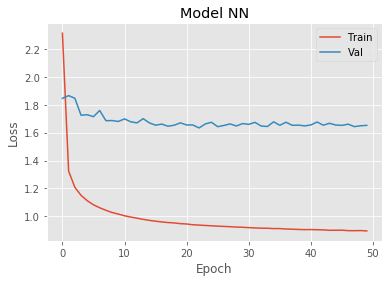

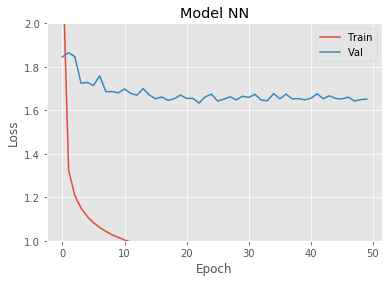

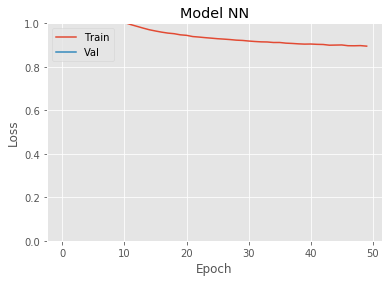

In [0]:
show_plot(hist) 

In [0]:
from keras.models import model_from_json

def load_model(dir = os.getcwd(), name = 'model'):
  json_file = open(os.path.join(dir,name+'.json'), 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  model.load_weights(os.path.join(dir,name+'.h5'))
  print("Loading is complete.")
  return model

In [0]:
nn = load_model(DIR, 'model_nn')
opt = Adam(lr = 0.05)
nn.compile(optimizer = opt, loss = mse)


In [0]:
from sklearn.utils import shuffle

k = nn.evaluate(X_val, y_val, batch_size = 800000, verbose = 0)
print(k)
for i in range(X_val.shape[1]):
    X_val_2 = X_val.copy()
    s = shuffle(X_val_2.iloc[:,i])
    s.index = X_val_2.index
    X_val_2.iloc[:, i] = s
    print('{}: {:2.5}'.format(cols[i], nn.evaluate(X_val_2, y_val, batch_size = 800000, verbose = 0) - k))
    X_val_2 = None

In [0]:
X_test.shape

In [0]:
p = nn.predict(X_test, batch_size = 100000)

In [0]:
df_sample_submission.to_csv(DIR+'out_file_int.csv', index = False)

In [0]:
df_sample_submission.head()

,row_id,meter_reading
8784,0,187.721802
8785,129,170.970444
8786,258,158.120926
8787,387,150.405380
8788,516,149.041794


In [0]:
df_sample_submission['row_id'] = df_sample_submission['row_id'].astype('Int32')
df_sample_submission['meter_reading'] = df_sample_submission['meter_reading'].astype('float16')